# 1. Data Understanding

## Data Collection

In [20]:
#importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential,Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers,regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import InceptionV3

from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

import os, shutil
import warnings
warnings.filterwarnings('ignore')
set_seed(111)

## 1.1 Data Analysis

In [21]:
root_folder = "/kaggle/input/vegetable-data/Vegetable_Classification"
train_path = os.path.join(root_folder,"Train")
test_path = os.path.join(root_folder,"Test")

In [22]:
#analysing the data
classes = os.listdir(train_path)
total_class = len(classes)
print("Total Number of Classes: ", total_class)

Total Number of Classes:  5


In [23]:
#finding the shape of image
class_name = classes[0]
image_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[0])
img = Image.open(image_path)
width, height = img.size
channels = len(img.getbands())
print("Image shape (width, height, channels):", (width, height, channels))

Image shape (width, height, channels): (100, 100, 3)


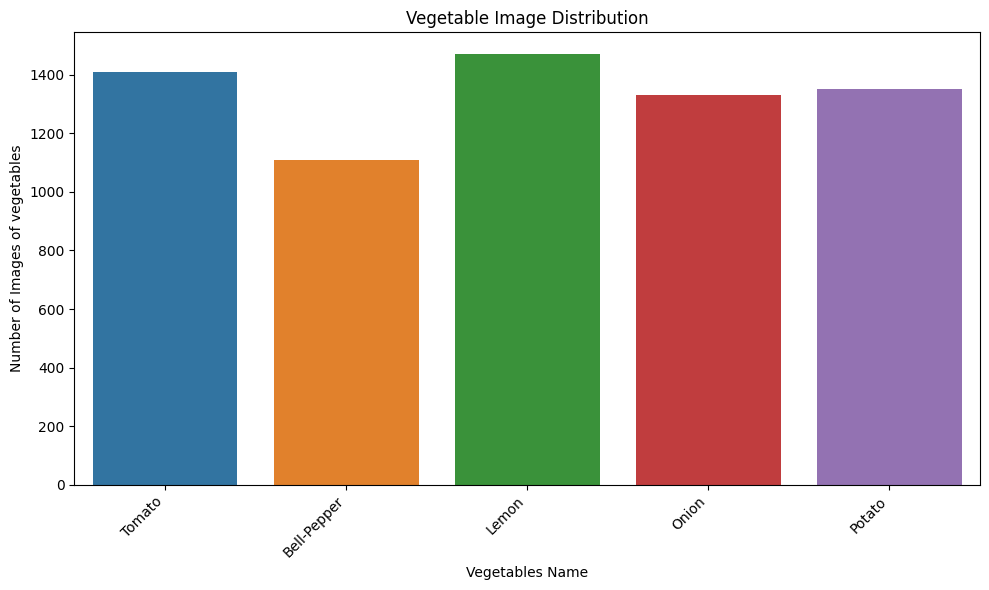

In [24]:
#distribution of data
class_names = []
num_images = []

# Iterate through each class directory
for class_dir in classes:
    class_path = os.path.join(train_path, class_dir)
    images_in_class = len(os.listdir(class_path))
    class_names.append(class_dir)
    num_images.append(images_in_class)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names,y=num_images)
plt.xlabel('Vegetables Name')
plt.ylabel('Number of Images of vegetables')
plt.title('Vegetable Image Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
#counting the number of data in train,test and validation
def count(path):
  count = 0
  for root, dirs, files in os.walk(path):
      for file in files:
          if file.endswith(".jpg") or file.endswith(".png"):
              count += 1
  return count

print("Total Number of Training Data: ",count(train_path))
print("Total Number of Test Data: ",count(test_path))

Total Number of Training Data:  6673
Total Number of Test Data:  5


## 1.2 Data Visualization

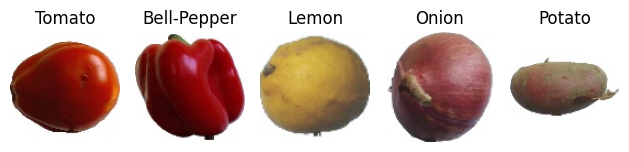

In [26]:
# Assuming `classes` is a list containing the class names
for class_name in classes:
    # Get list of image files in current class directory
    class_path = os.path.join(train_path, class_name)
    image_files = os.listdir(class_path)

    # Load and display one image from current class
    if len(image_files) > 0:
        # Choose the first image from the class
        image_path = os.path.join(class_path, image_files[0])
        img = Image.open(image_path)

        # Display image with class name as title
        plt.subplot(1, len(classes), classes.index(class_name) + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [27]:

# # Check for corrupted images and remove them
# corrupted_images = []
# for class_name in classes:
#     class_path = os.path.join(train_path, class_name)
#     for image_name in os.listdir(class_path):
#         image_path = os.path.join(class_path, image_name)
#         try:
#             img = Image.open(image_path)
#             img.verify()  # Verify if image is valid
#         except (IOError, SyntaxError) as e:
#             corrupted_images.append(image_path)
#             os.remove(image_path)  # Remove corrupted image
#             print(f"Removed corrupted image: {image_path}")

# # Print list of corrupted images if any
# if corrupted_images:
#     print("Corrupted images found:")
#     for image_path in corrupted_images:
#         print(image_path)
# else:
#     print("No corrupted images found.")

## 1.3 Data Pre Processing

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions, batch size, and validation split
image_width, image_height = width, height
batch_size = 32
validation_split = 0.2

# Define the training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Flow from directory for the training dataset
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

# Image dataset from directory for the validation dataset
valid_datagen = ImageDataGenerator(rescale=1. / 255)  # Only rescaling for validation

valid_ds = valid_datagen.flow_from_directory(
    train_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',  
)

# Image dataset from directory for the test dataset
test_datagen = ImageDataGenerator(rescale=1. / 255)  # Only rescaling for testing

test_ds = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse', 
    shuffle=False
)

Found 6673 images belonging to 5 classes.
Found 6673 images belonging to 5 classes.
Found 5 images belonging to 5 classes.


In [29]:
# rescale_factor = 1.0 / 255

# test_ds = test_ds.map(lambda x, y: (x * rescale_factor, y))
# valid_ds = valid_ds.map(lambda x,y : (x * rescale_factor, y))

# 2. Building Fully Connected Neural Network

## 2.1 Model Building

In [61]:
model_fcnn = tf.keras.Sequential([
        layers.Flatten(input_shape=(image_width, image_height, 3)),
        layers.Dense(units=1024, activation='relu'), 
        layers.Dense(units=256, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=5, activation='softmax'), 
    ]
)

model_fcnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │    30,721,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,016,965 (118.32 MB)

 Trainable params: 31,016,965 (118.32 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model_fcnn.compile(optimizer = Adam(learning_rate = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_fcnn = model_fcnn.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)

Epoch 1/15
  3/209 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.2830 - loss: 9.0490

W0000 00:00:1715355100.019962     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/209 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.4518 - loss: 9.9944  

W0000 00:00:1715355117.810484     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/209 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5180 - loss: 7.7118

W0000 00:00:1715355126.712660     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715355133.763682     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 164ms/step - accuracy: 0.5201 - loss: 7.6433 - val_accuracy: 0.7948 - val_loss: 0.4368
Epoch 2/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.8047 - loss: 0.5272 - val_accuracy: 0.9245 - val_loss: 0.2025
Epoch 3/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.8400 - loss: 0.4260 - val_accuracy: 0.9380 - val_loss: 0.1858
Epoch 4/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 150ms/step - accuracy: 0.8974 - loss: 0.2592 - val_accuracy: 0.9606 - val_loss: 0.1250
Epoch 5/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.9130 - loss: 0.2205 - val_accuracy: 0.9565 - val_loss: 0.0977
Epoch 6/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 34s 160ms/step - accuracy: 0.9309 - loss: 0.1991 - val_accuracy: 0.9769 - val_loss: 0.0593
Epoch 7/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 32s 149ms/step - accuracy: 0.9276 - loss: 0.1708 - val_accuracy: 0.9555 - val_loss: 0.1122
Epoch 8/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9300 - loss: 0.1718 - val

In [64]:
def plotAccuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  plt.plot(acc,label='train accuracy',color='blue')
  plt.plot(val_acc,label='validation accuracy',color='blue',linestyle='dashed')
  plt.legend(loc='lower right')
  plt.title('Training V/S Validation Accuracy')
  plt.show()

def plotLoss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(loss,label="train loss",color='red')
  plt.plot(val_loss,label="validation loss",color='red',linestyle='dashed')
  plt.legend(loc='upper right')
  plt.title('Training V/S Validation Loss')
  plt.show()

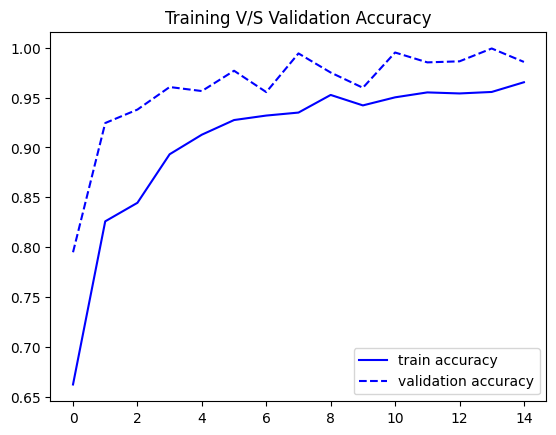

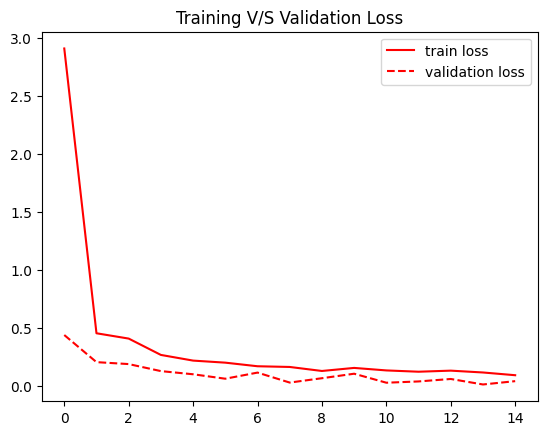

In [65]:
plotAccuracy(history_fcnn)
plotLoss(history_fcnn)

## 2.3 Evaluation of Model

In [66]:
def evaluateModel(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

In [67]:
evaluateModel(model_fcnn,test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 1.0000 - loss: 0.0016
Test Loss: 0.0015844492008909583
Test Accuracy: 1.0


## 2.4 Prediction

In [68]:
def predict(model,image_path):
    classes_labels = ["Bell-Pepper","Lemon","Onion","Potato","Tomato"]
    img = image.load_img(image_path, target_size=(100, 100))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = classes_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted class label: " + predicted_class_label)
    plt.show()

    print("Predicted class label:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


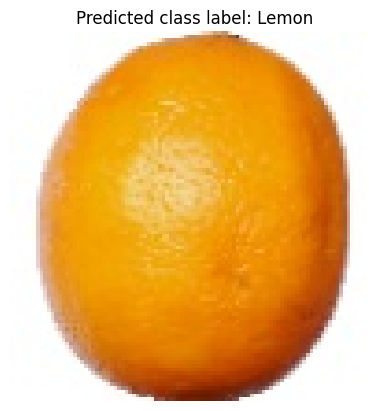

Predicted class label: Lemon


In [69]:
predict(model_fcnn,"/kaggle/input/vegetable-data/Vegetable_Classification/Test/Lemon/9_100(1).jpg")

# 3. Building Convolutional Neural Network

## 3.1 Model Building

In [177]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu'),
    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu'),
    layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="selu", kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(64, activation="selu"),
    layers.Dense(32, activation="selu"),
    layers.Dropout(0.3),
    layers.Dense(units=5, activation='softmax')
])

In [178]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_144 (Conv2D)             │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 25, 25, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 25, 25, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,053 (336.14 KB)

 Trainable params: 86,053 (336.14 KB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Training the Model

In [181]:
model.compile(optimizer = SGD(learning_rate=0.001, momentum=0.8),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [182]:
epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)

Epoch 1/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.2590 - loss: 1.8055 - val_accuracy: 0.4749 - val_loss: 1.6769
Epoch 2/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.4204 - loss: 1.5671 - val_accuracy: 0.4831 - val_loss: 1.2182
Epoch 3/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.4863 - loss: 1.2144 - val_accuracy: 0.7139 - val_loss: 0.9095
Epoch 4/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.6582 - loss: 0.9089 - val_accuracy: 0.7583 - val_loss: 0.7294
Epoch 5/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.7642 - loss: 0.7199 - val_accuracy: 0.8404 - val_loss: 0.5529
Epoch 6/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.8231 - loss: 0.6099 - val_accuracy: 0.8873 - val_loss: 0.5061
Epoch 7/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.8722 - loss: 0.5011 - val_accuracy: 0.8945 - val_loss: 0.4917
Epoch 8/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.8786 - loss: 0

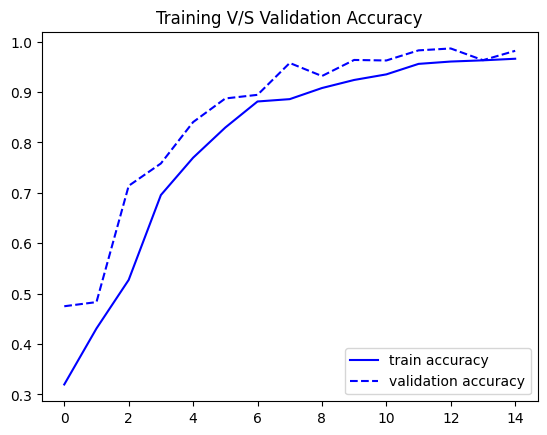

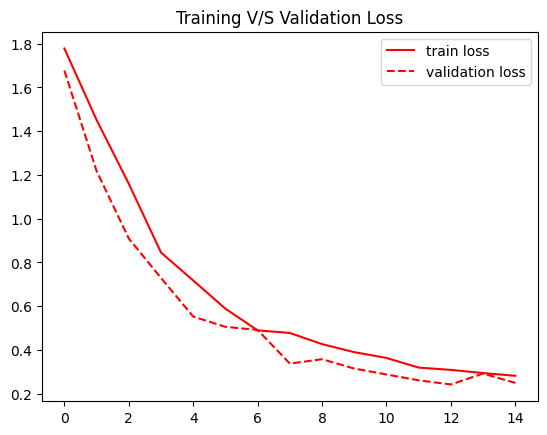

In [183]:
plotAccuracy(history)
plotLoss(history)

## 3.3 Evaluation of Model

In [310]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.2128
Test Loss: 0.2128489464521408
Test Accuracy: 1.0


## 3.4 Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


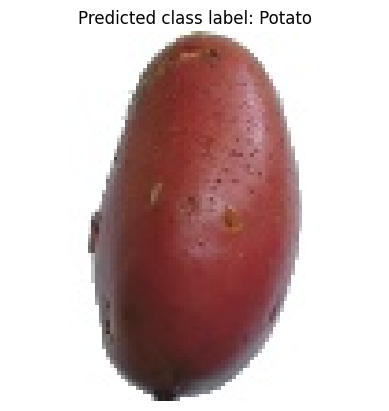

Predicted class label: Potato


In [309]:
predict(model,"/kaggle/input/vegetable-data/Vegetable_Classification/Train/Potato/109_100(1).jpg")

# 4. Transfer Learning

## 4.1 Selecting and Loading Pre-trained Model

In [12]:
from keras.applications import VGG16

pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[image_width,image_height, 3])
pretrained_model.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 4.2 Restructure of Model

In [19]:
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [20]:
vgg16_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## 4.3 Training the Model (Fine Tuning)

In [23]:
input_tensor = tf.keras.Input(shape=[image_width, image_height, 3])
output_tensor = vgg16_model(input_tensor) 
# Combine the base model and custom layers into a single model
train_vgg16_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
train_vgg16_model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.8),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = train_vgg16_model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]
)

Epoch 1/15
  1/209 ━━━━━━━━━━━━━━━━━━━━ 42:54 12s/step - accuracy: 0.1875 - loss: 1.8950

I0000 00:00:1715336198.974003     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715336198.994306     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3540 - loss: 1.5309

W0000 00:00:1715336261.267636     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


209/209 ━━━━━━━━━━━━━━━━━━━━ 87s 357ms/step - accuracy: 0.3554 - loss: 1.5292 - val_accuracy: 0.6475 - val_loss: 1.0346
Epoch 2/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.7445 - loss: 1.0084 - val_accuracy: 0.8839 - val_loss: 0.7047
Epoch 3/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8176 - loss: 0.7761 - val_accuracy: 0.8825 - val_loss: 0.5502
Epoch 4/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 186ms/step - accuracy: 0.8538 - loss: 0.6238 - val_accuracy: 0.9182 - val_loss: 0.4421
Epoch 5/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.8770 - loss: 0.5286 - val_accuracy: 0.9203 - val_loss: 0.3803
Epoch 6/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8954 - loss: 0.4564 - val_accuracy: 0.9293 - val_loss: 0.3320
Epoch 7/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.9057 - loss: 0.4163 - val_accuracy: 0.9236 - val_loss: 0.3039
Epoch 8/15
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.9164 - loss: 0.3704 - val

## 4.4 Model Evaluation

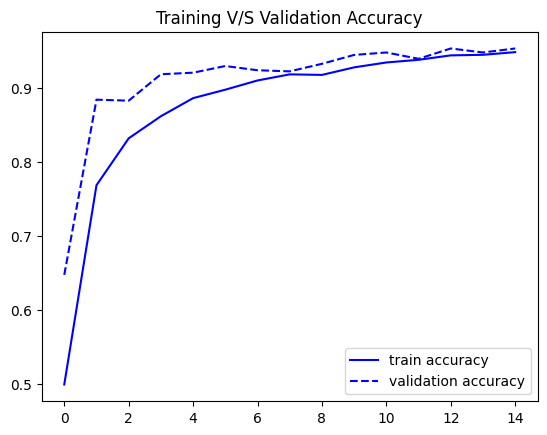

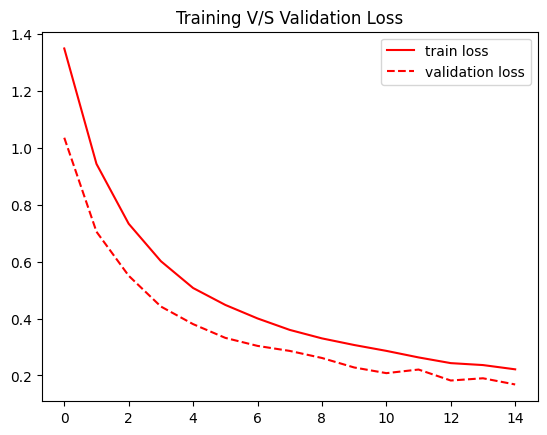

In [68]:
plotAccuracy(history)
plotLoss(history)

In [69]:
evaluateModel(train_vgg16_model,test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0925
Test Loss: 0.09250925481319427
Test Accuracy: 1.0


W0000 00:00:1715339492.409610     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
